In [1]:
import numpy as np
import pandas as pd
import locale
import matplotlib.pyplot as plt
import seaborn as sns
import scrape_functions as sf

# First the Scraping

In [4]:
locale.setlocale(locale.LC_ALL, "sv_SE.UTF-8")

'sv_SE.UTF-8'

In [3]:
url = "https://www.hemnet.se/salda/bostader?location_ids%5B%5D=505426"

In [5]:
soup_list = sf.hemnet_pull_all(url)

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Get LATEST driver version for 94.0.4606
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/94.0.4606.61/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/ivenwinkelmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61]
/Users/ivenwinkelmann/Documents/GitHub/Portfolio/hemnet/scrape_functions.py:12: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 12 of the file /Users/ivenwinkelmann/Documents/GitHub/Portfolio/hemnet/scrape_functions.py. To get rid of this warning, pass the additional argument 

In [ ]:
entry_key = "li.sold-results__normal-hit"
keys = {
      "street": "span.item-result-meta-attribute-is-bold.item-link.qa-selling-price-title"
    , "size_m2": "div.sold-property-listing__size > div > div.sold-property-listing__subheading.sold-property-listing--left"
    , "fee": "div.sold-property-listing__fee"
    , "price": "div.sold-property-listing__price > div:nth-child(1) > span"
    , "price_p_m2": "div.sold-property-listing__price-per-m2.sold-property-listing--left"
    , "date": "div.sold-property-listing__price > div:nth-child(2) > div.sold-property-listing__sold-date.sold-property-listing--left"
}

entry_list = sf.container_list_gen(entry_key, soup_list)

df = sf.container_scrape(entry_list, keys)

In [ ]:
# fix fee column
# df["fee"] = df["fee"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("kr/mån", "").str.strip().astype("int")

# fix price column
df["price"] = df["price"].str.replace(" ", "").str.replace(r"\xa0", "").str.replace("Slutpris", "")\
    .str.replace("kr", "").str.strip()

# fix price_p_m2 column
df["price_p_m2"] = df["price_p_m2"].str.replace(" ", "").str.replace(r"\xa0", "")\
    .str.replace("kr/m²", "").str.strip()
    
# fix date column
df["date"] = df["date"].str.replace("Såld", "").str.strip()
df["date"] = pd.to_datetime(df["date"], format="%d %B %Y") 

# add month sold
df["month_sold"] = df["date"].dt.month

# add year sold
df["year_sold"] = df["date"].dt.year

In [ ]:
sf.save_object(df, "hemnet_df.pkl")

# Now the Analysis
## Guiding Questions
- What are the differences between housenumbers?
    - Value? Number of Apartments sold?
- How did the fee change over time?
- Which broker is most performant?
- How is the general price trend?
- Which months outperform the average?
- Different categories of apartment sizes?
- What size is the sweetspot for value?
- How many apartments sold per year?

In [11]:
def figure_style():
#     plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize=(9, 6), dpi=300)
    sns.set_style("whitegrid")
    # plt.style.use("white_background")
    plt.rc('font', weight='bold')
    plt.rcParams.update({
        "axes.labelsize": 18
        , "axes.labelweight": "1000"
        , "text.latex.preamble": r'\usepackage{sfmath} \boldmath'
        , "xtick.labelsize": 16
        , "ytick.labelsize": 16
        , "legend.fontsize": 14
        , "axes.linewidth": 0
        , "grid.color": "#666"
        , "patch.edgecolor": "None"
        , "scatter.edgecolors": "None"
        , "lines.markeredgecolor": "None"
        , "lines.linewidth": "3"
    })

In [12]:
house_order = pd.Index([2, 4, 6, 8, 10, 12, 27, 25, 23, 21, 19, 17, 15, 13, 11, 9, 7, 5], name="housenumber")

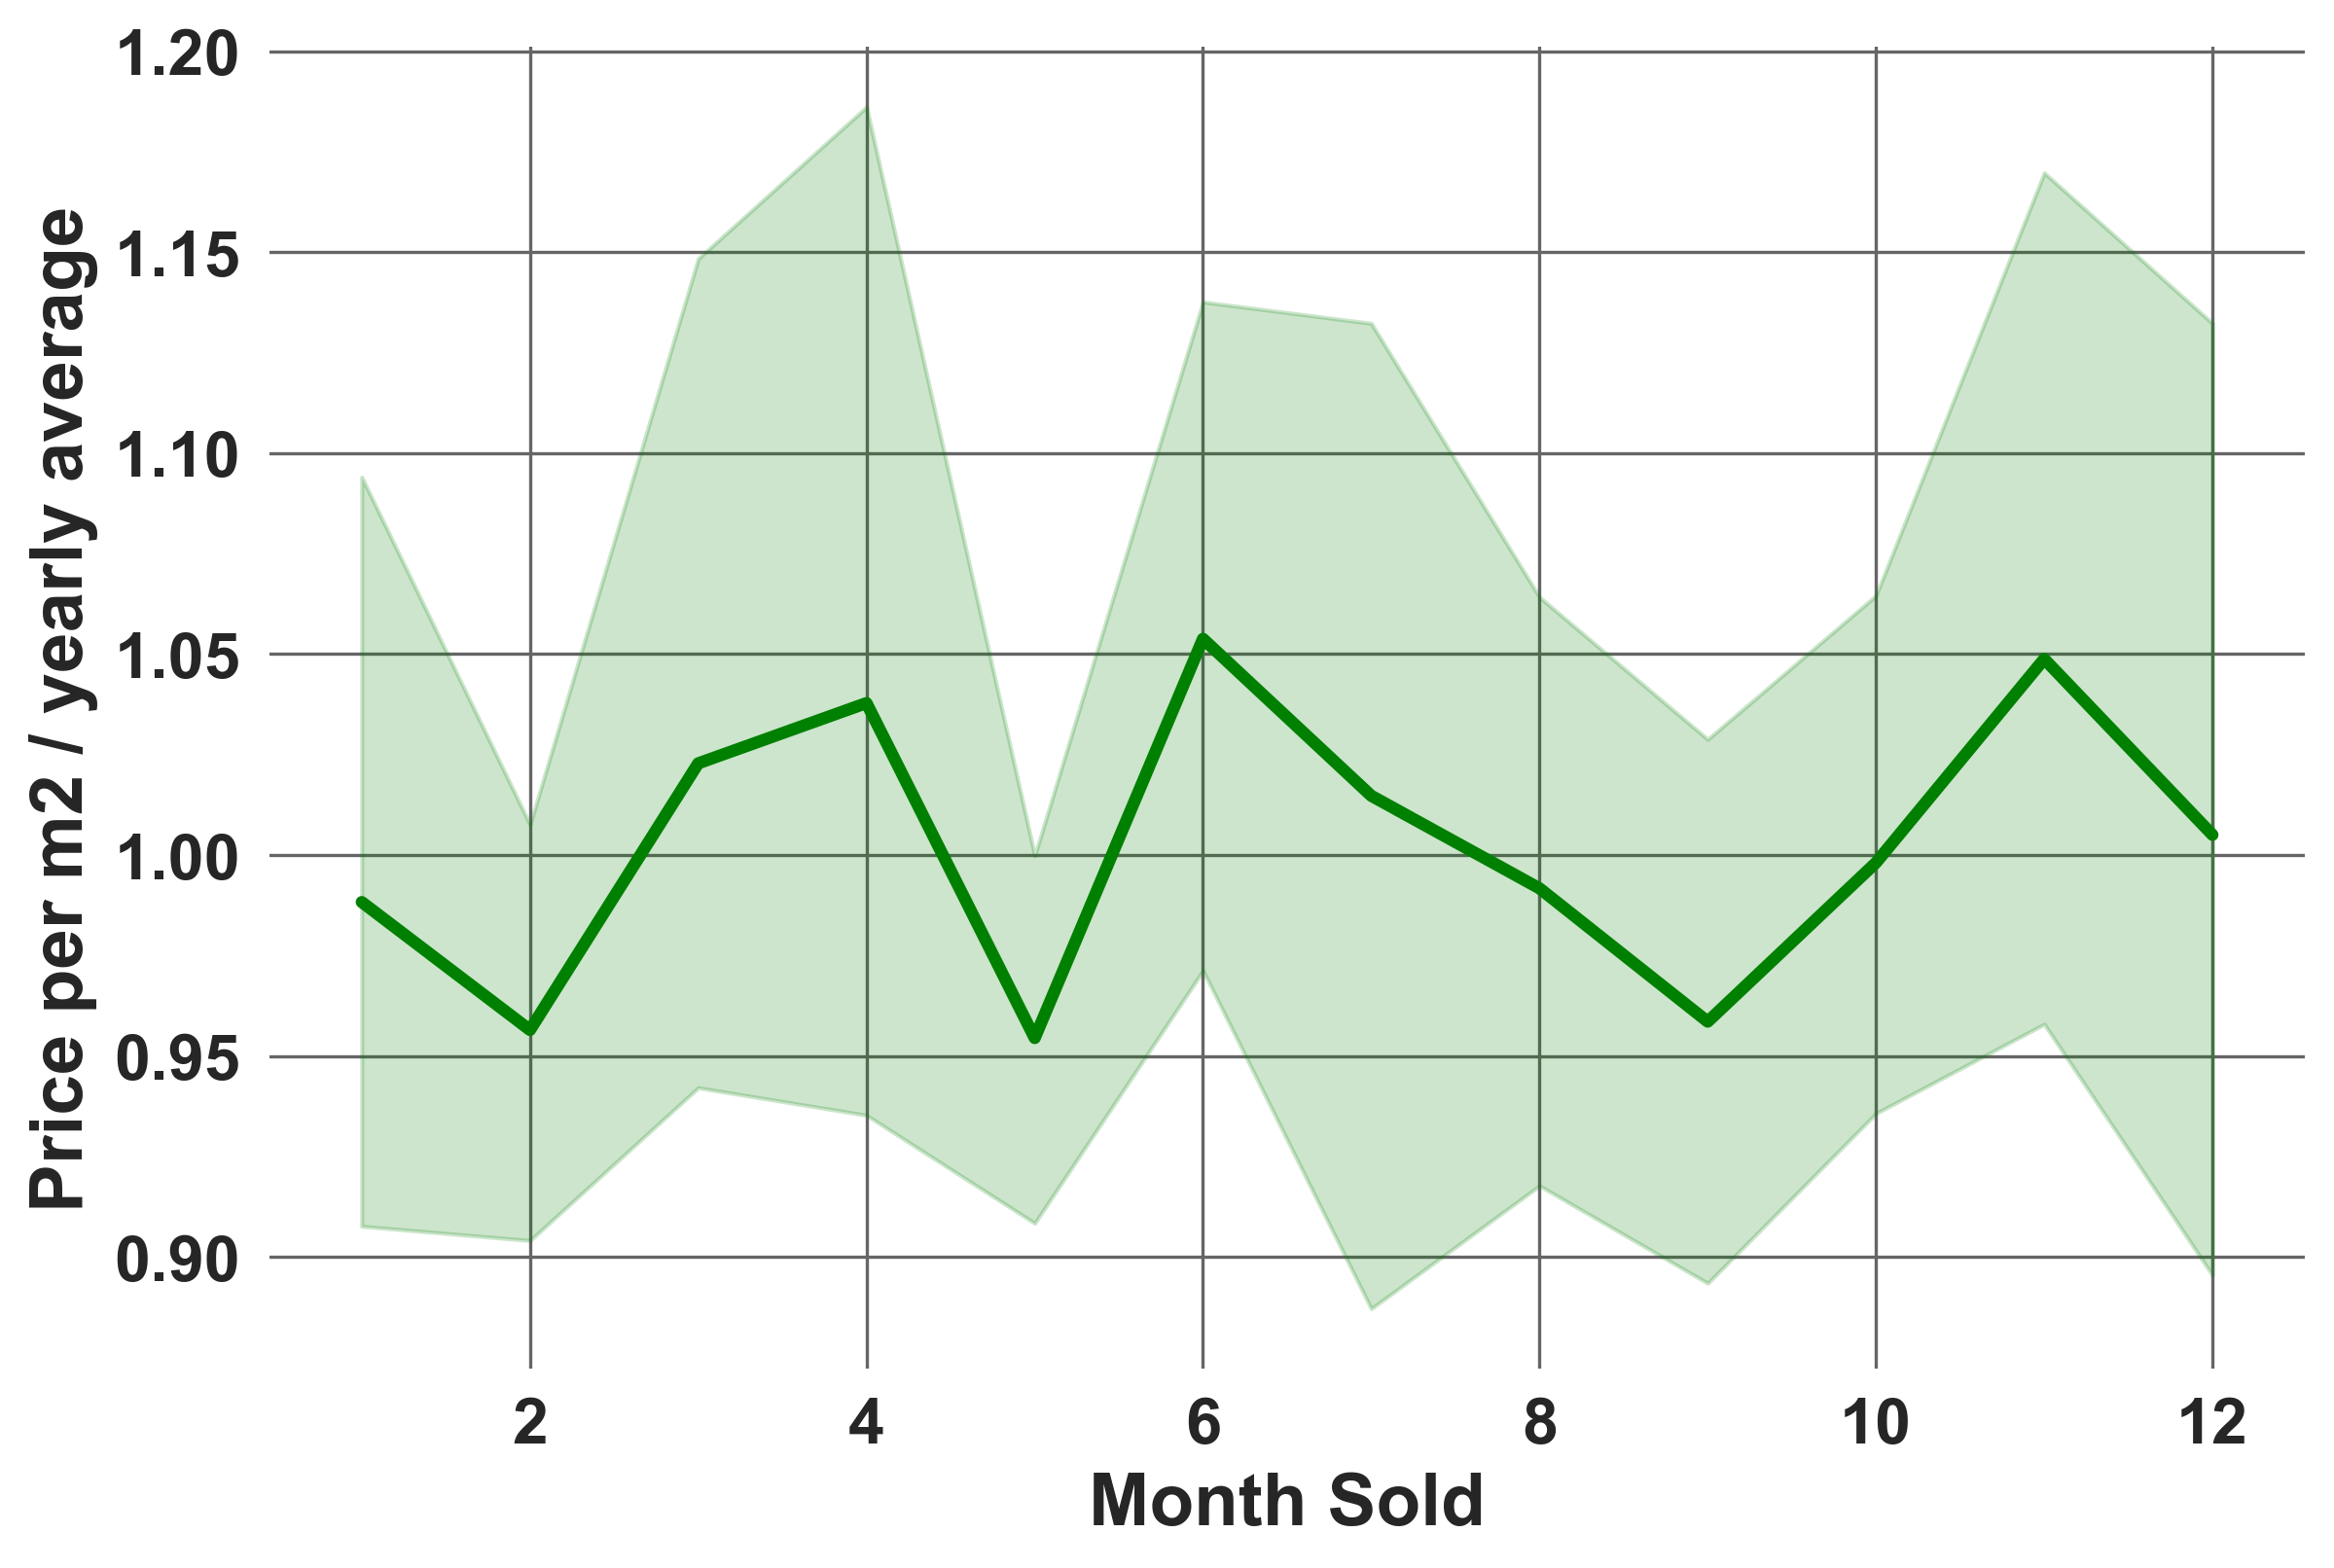

In [13]:
figure_style()
sns.lineplot(data=df, x="month_sold", y="price_m2_yr_norm", color="green")
plt.xlabel("Month Sold")
plt.ylabel("Price per m2 / yearly average")
plt.show()

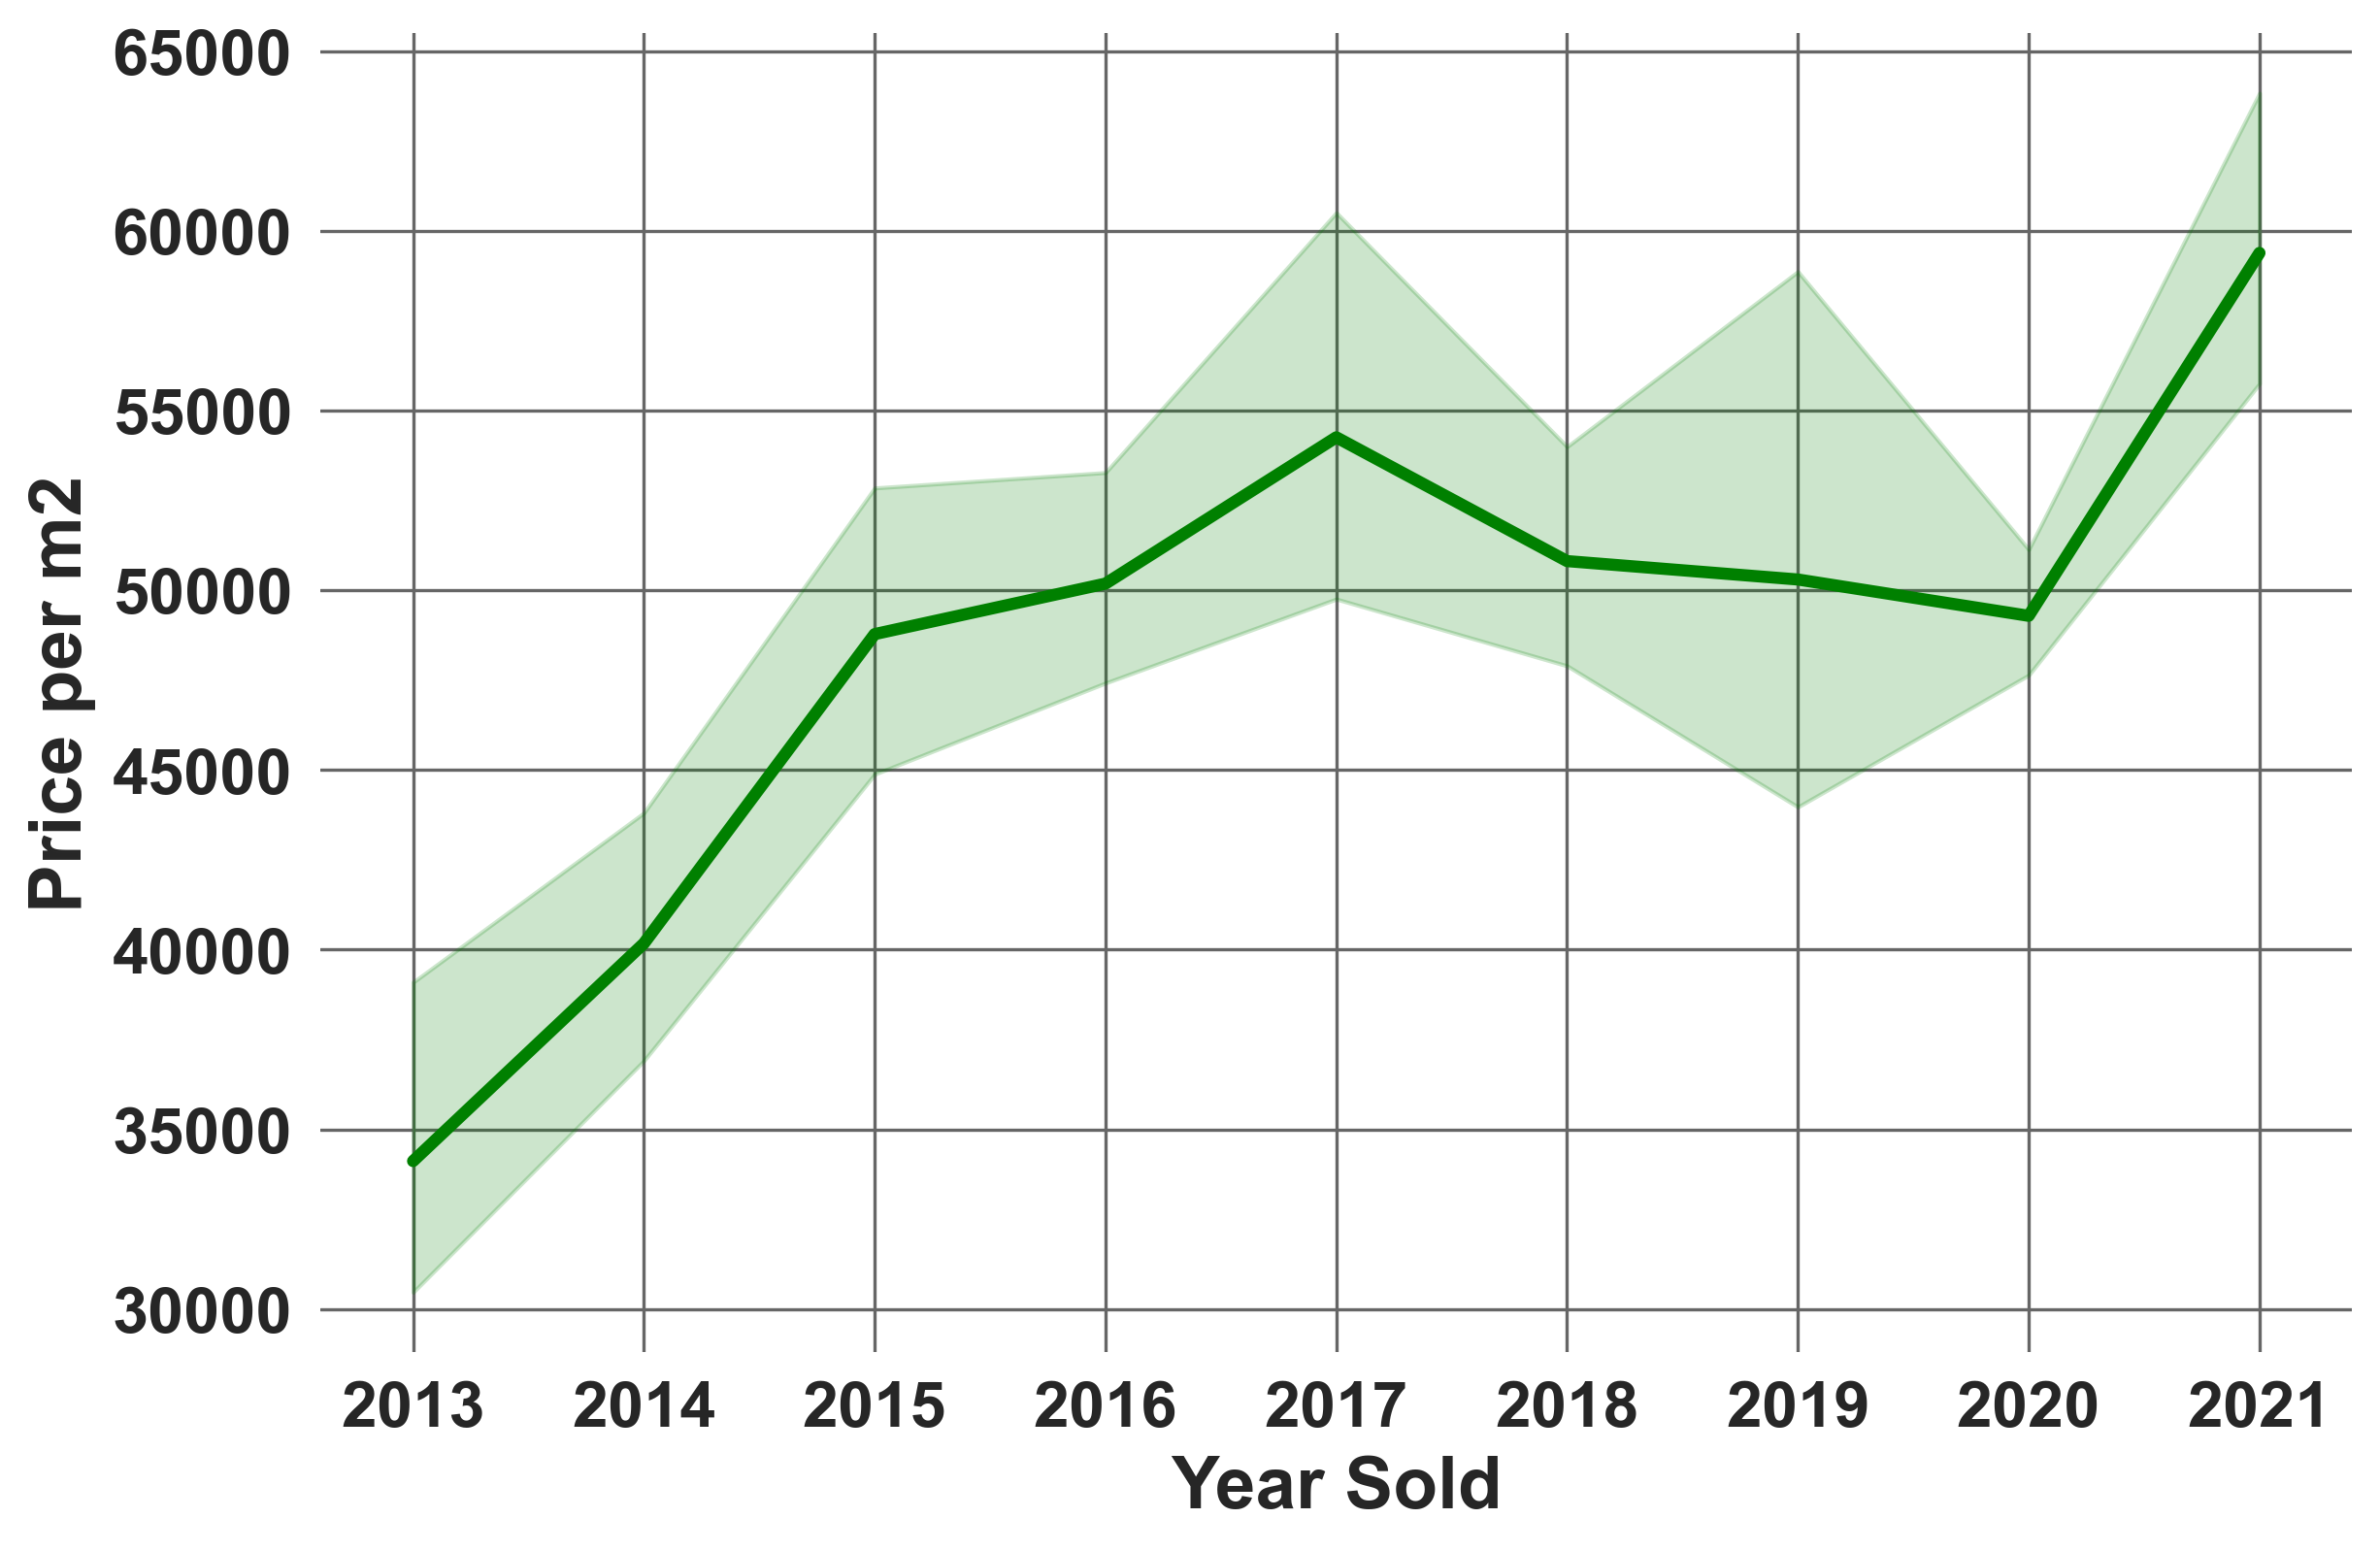

In [ ]:
figure_style()
sns.lineplot(data=df, x="year_sold", y="price_p_m2", color="green")
plt.xlabel("Year Sold")
plt.ylabel("Price per m2")
plt.show()


In [ ]:
df["broker"].value_counts(normalize=True)

Länsförsäkringar Fastighetsförmedling Solna         0.291667
Fastighetsbyrån Solna                               0.220238
Notar                                               0.059524
Erik Olsson Fastighetsförmedling                    0.059524
Svensk Fastighetsförmedling                         0.047619
Svensk Fastighetsförmedling Solna                   0.041667
Svenska Mäklarhuset Solna                           0.035714
Bjurfors Solna Sundbyberg                           0.029762
HusmanHagberg Solna                                 0.029762
Mäklarhuset Solna                                   0.023810
SkandiaMäklarna Solna                               0.023810
Unik Fastighetsförmedling AB                        0.023810
Bronze Fastighetsförmedling AB                      0.017857
MOHV Solna                                          0.017857
One Fastighetsmäkleri AB                            0.011905
Svenska Mäklarhuset Sundbyberg                      0.011905
Historiska Hem          

<AxesSubplot:xlabel='date', ylabel='fee_p_m2'>

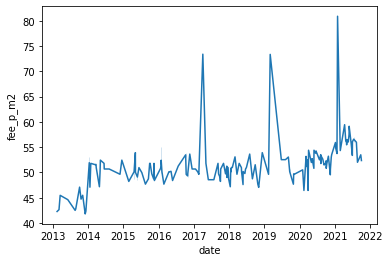

In [ ]:
sns.lineplot(data=df, x="date", y="fee_p_m2")

<AxesSubplot:xlabel='housenumber', ylabel='price_p_m2'>

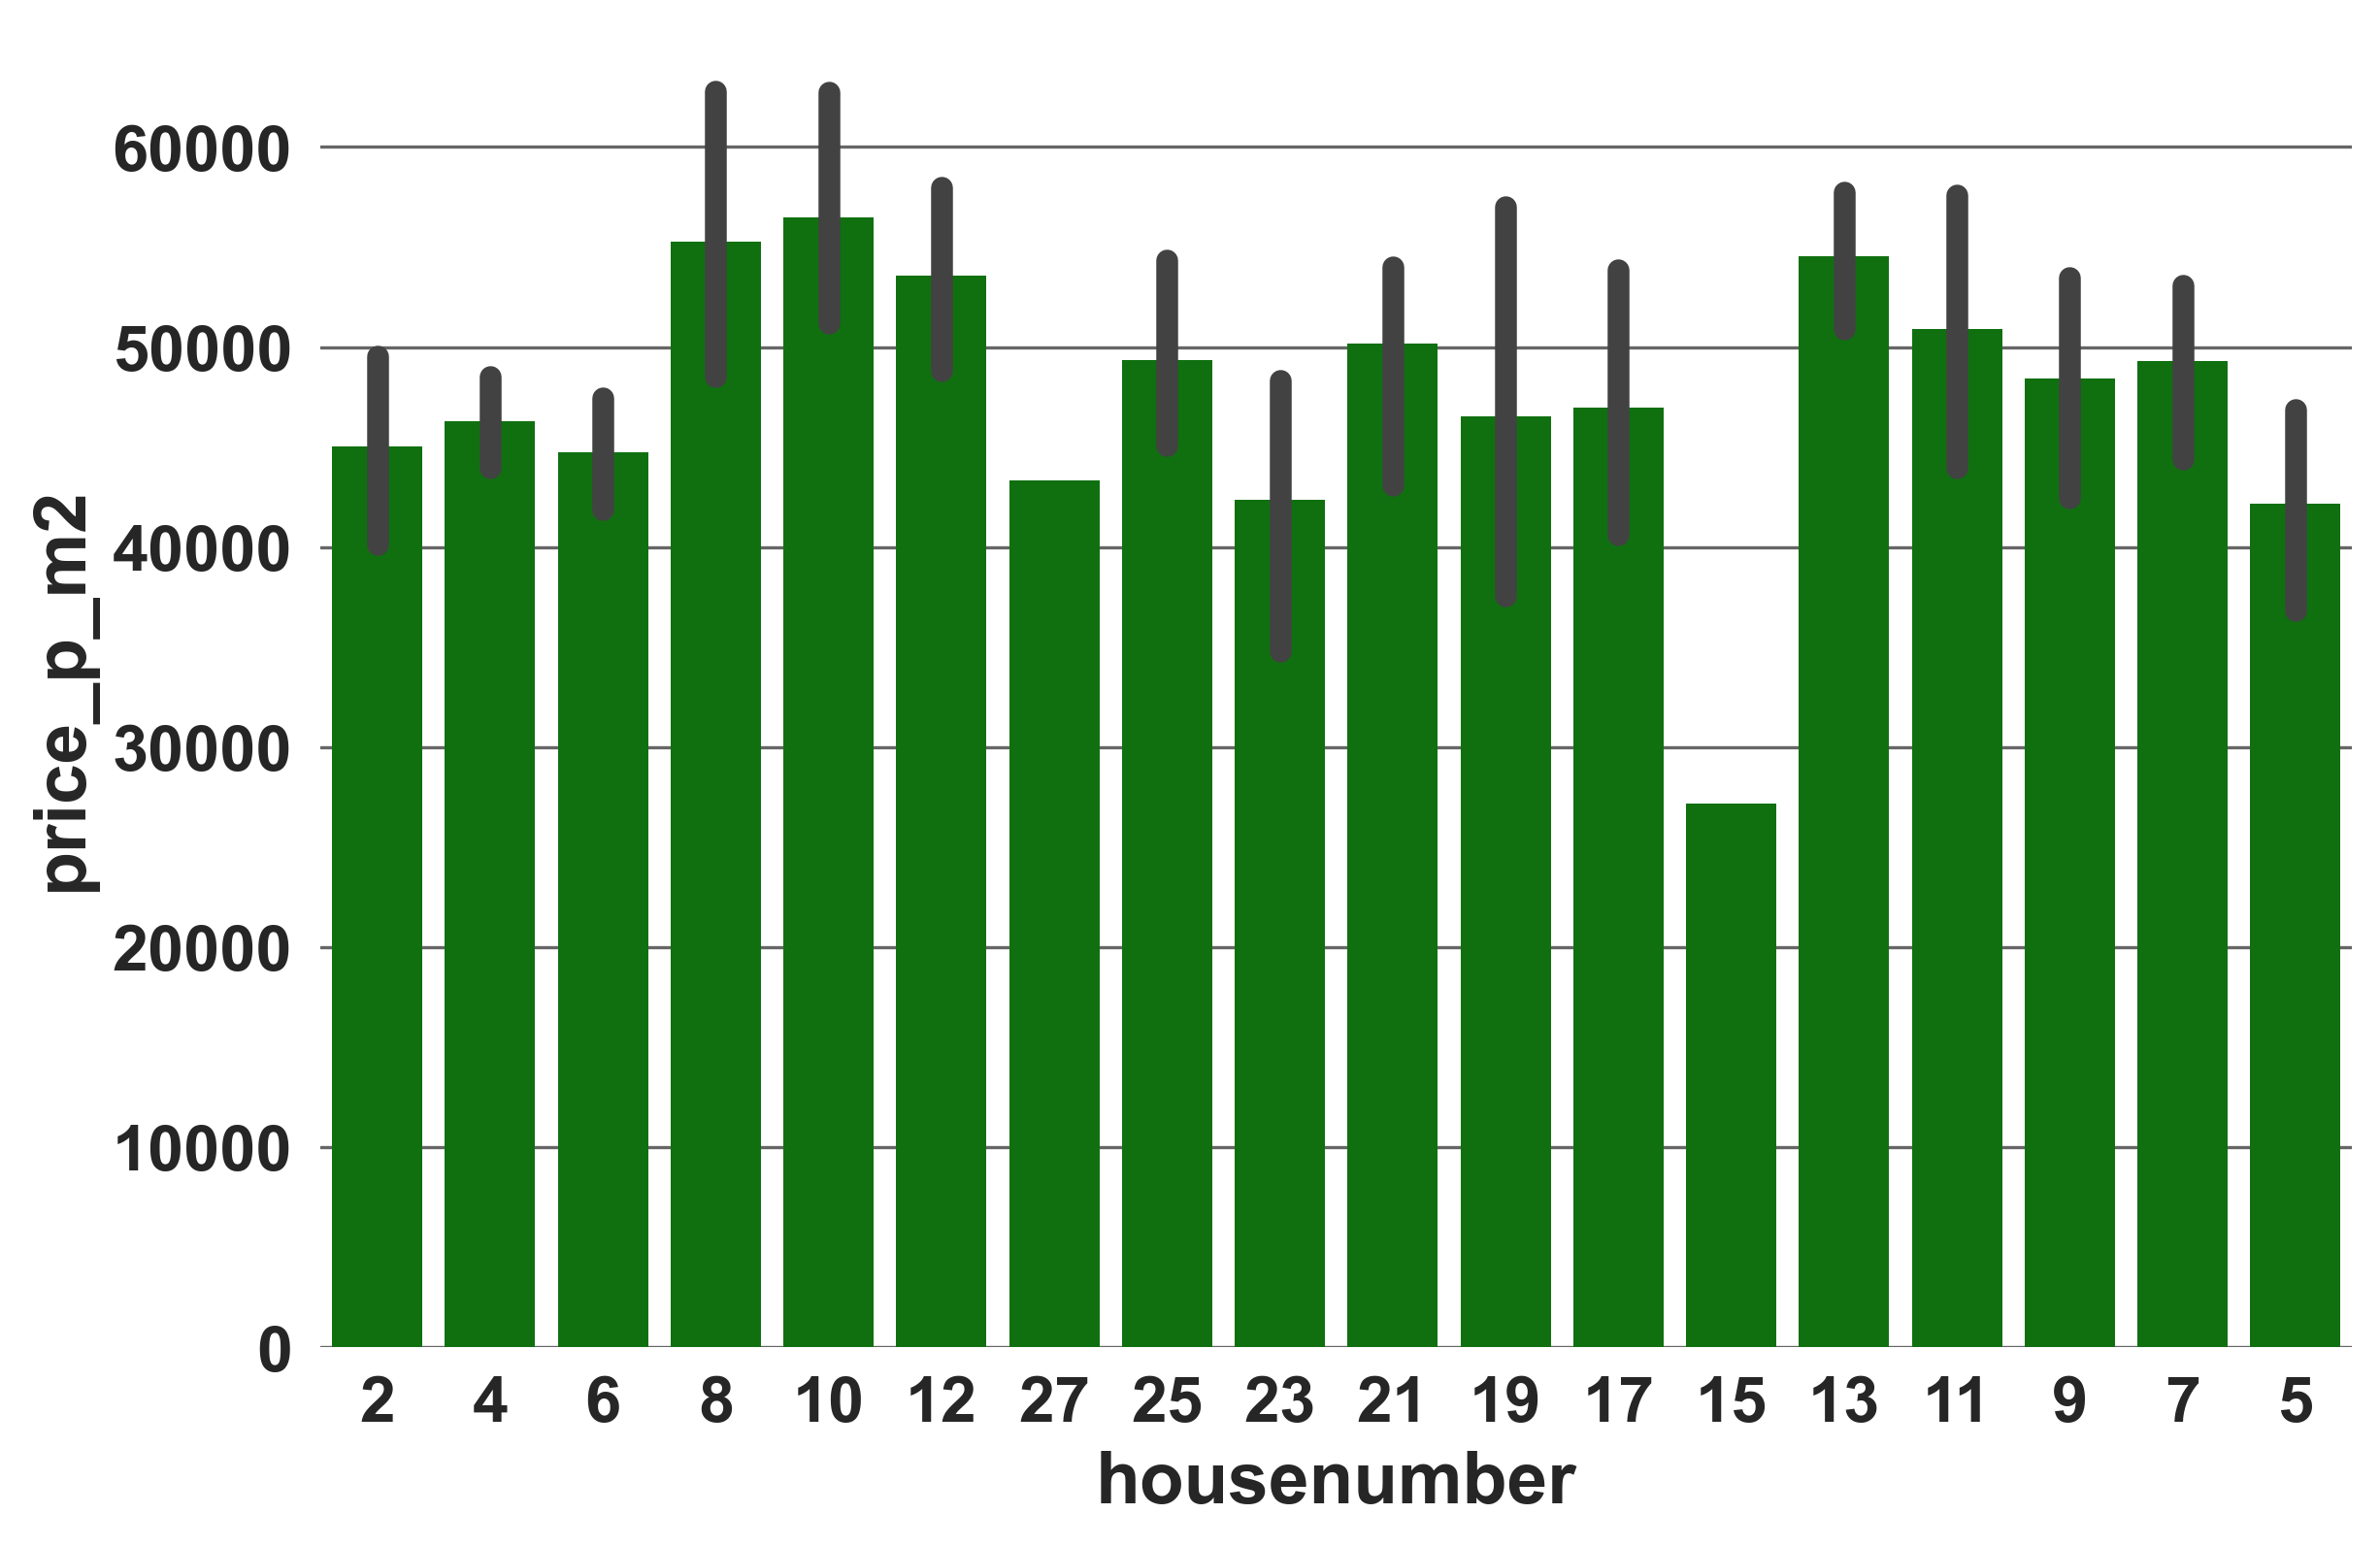

In [ ]:
figure_style()
sns.barplot(data=df, x="housenumber", y="price_p_m2", order=house_order, color="green")

Text(0, 0.5, 'Apartments sold per house')

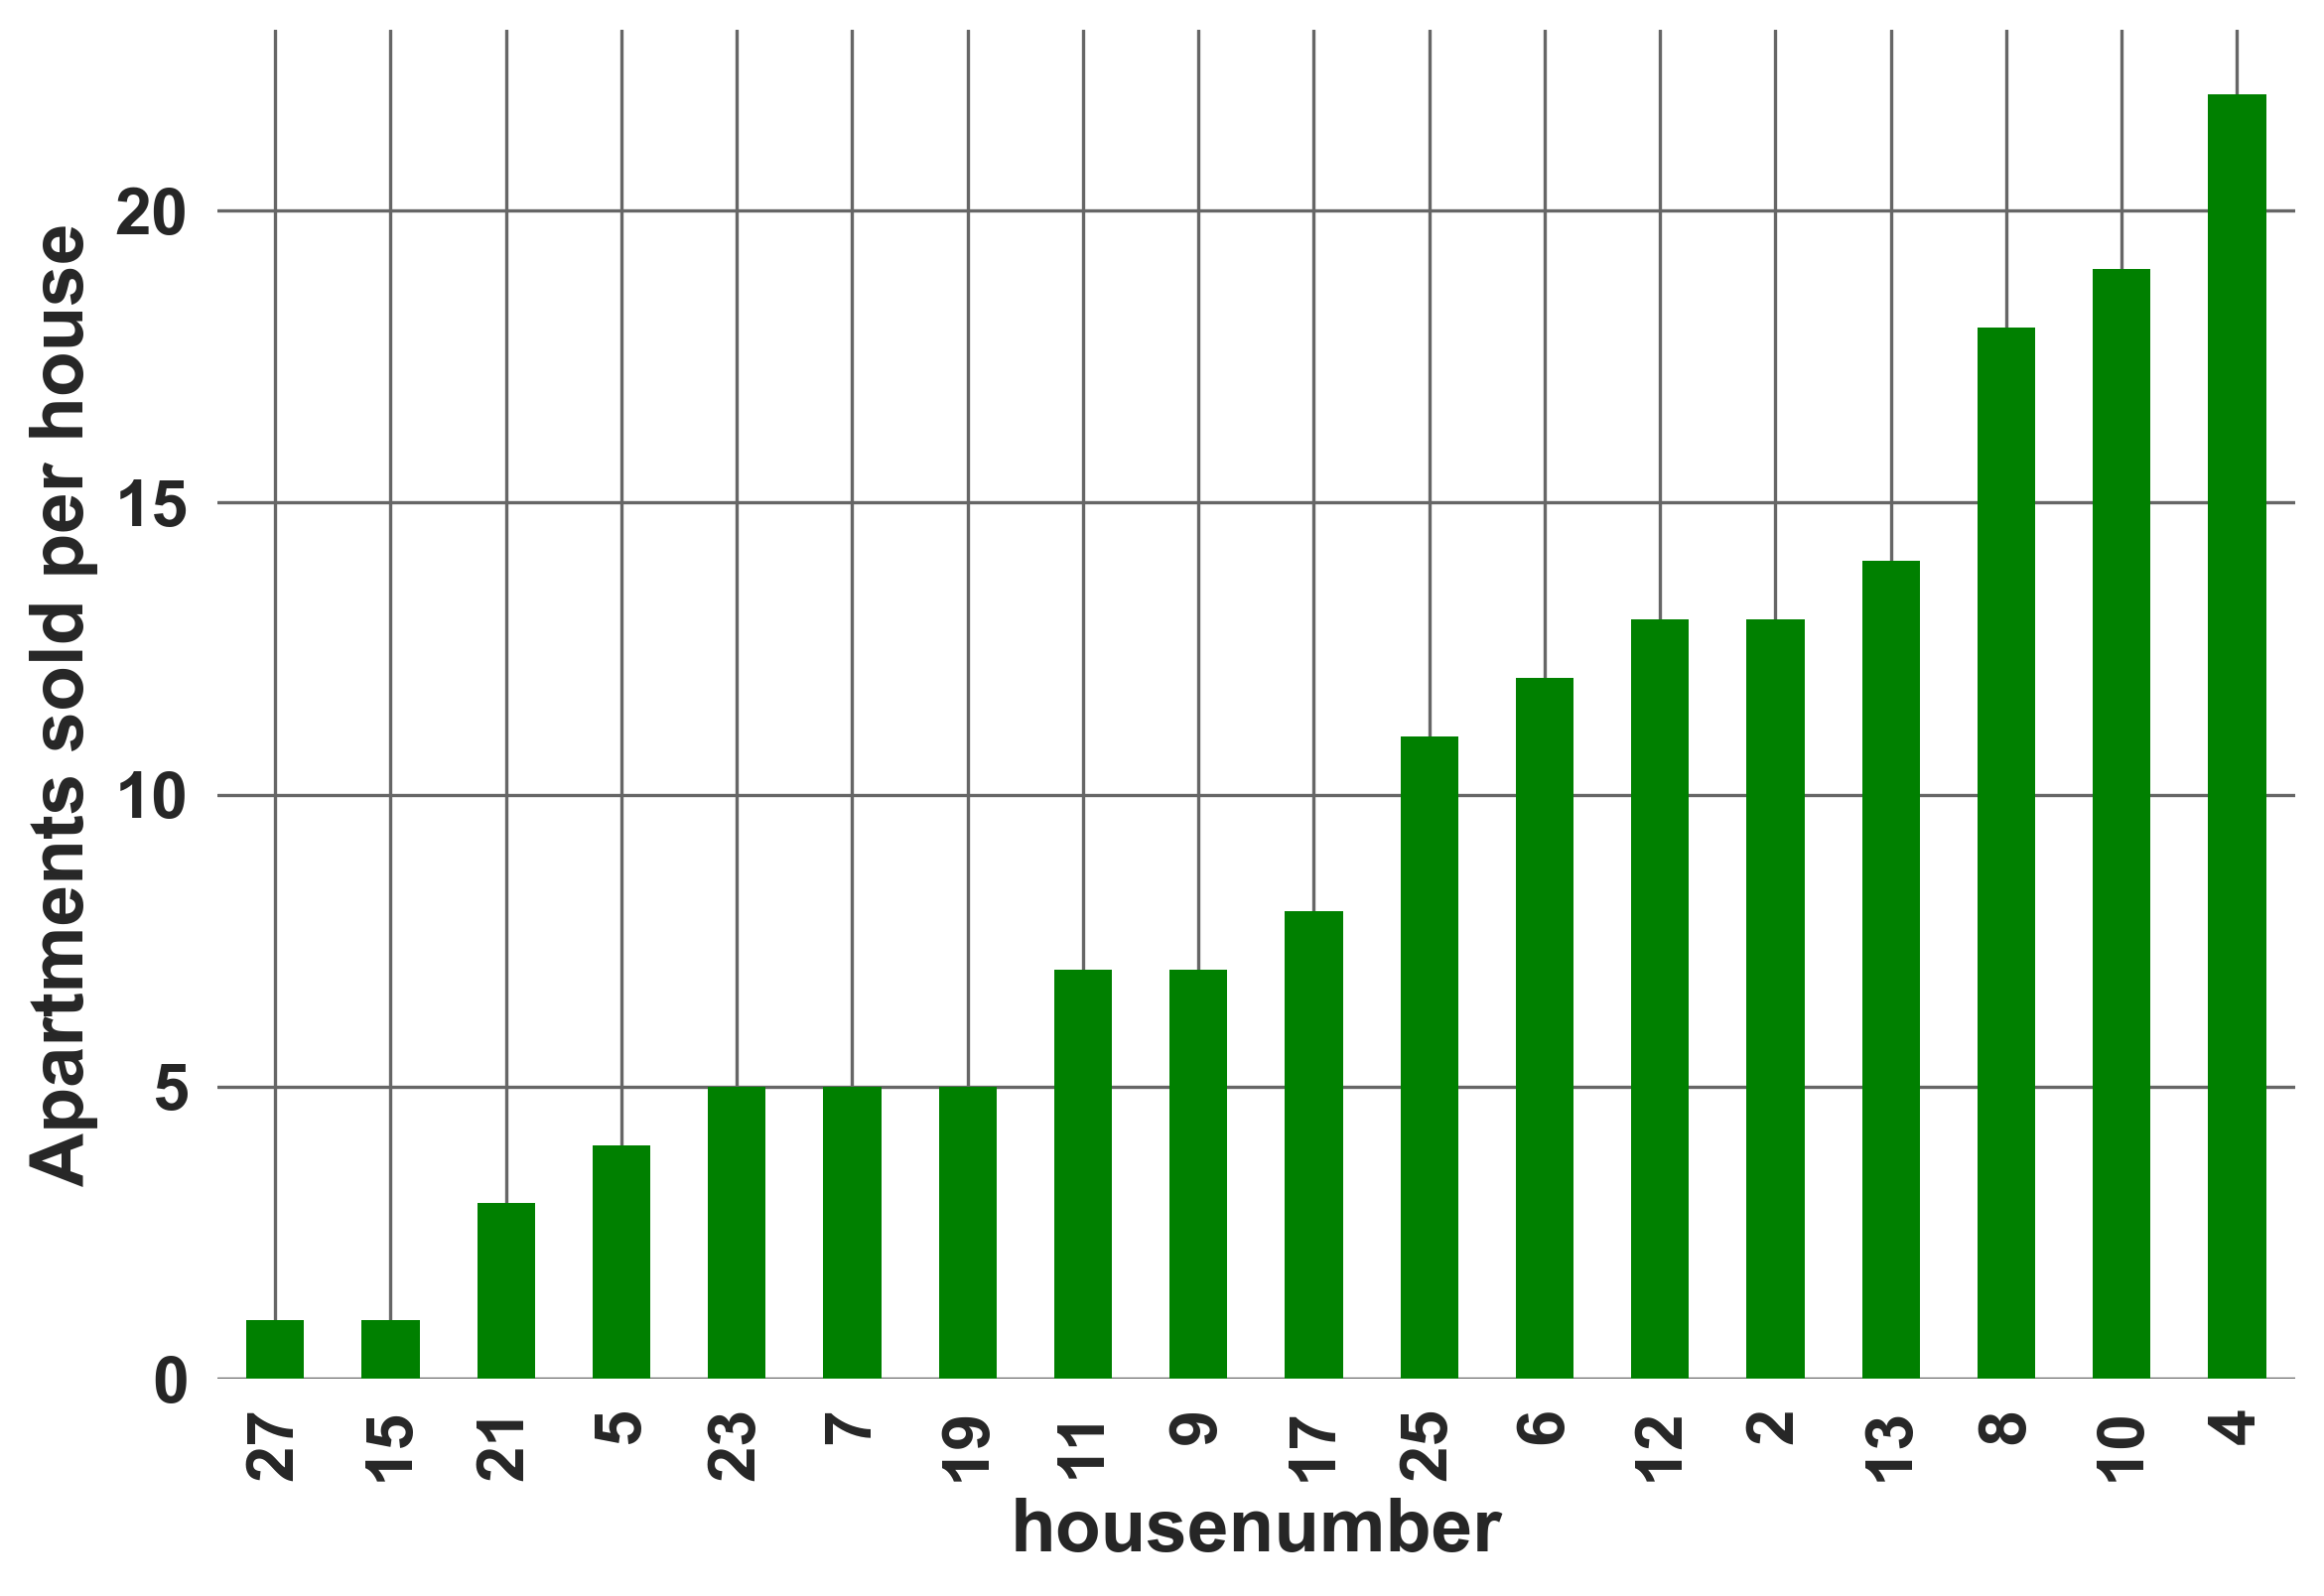

In [ ]:
figure_style()
ax = df.groupby(["housenumber"])["street"].count().sort_values().plot.bar(color="green")
plt.ylabel("Apartments sold per house")